In [2]:
import glob
import json
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline

# Add src/ path to get other scripts
cwd = Path(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(cwd.parent.absolute()))

import helpers.utilities as utils

logger = utils.create_logger()

def print_as_json(dictionary):
    print(json.dumps(dictionary, indent=4, ensure_ascii=False))

Load all PB files from `/src/analytics/pb_files directory`

In [3]:
path_to_pb_files = os.path.join(cwd, "pb_files", "*.pb")
files = glob.glob(path_to_pb_files)

counter = 0

all_files = {}

for pb_file in files:
    filename = os.path.basename(pb_file)
    # logger.info(f"Loading file: `{filename}`...")
    counter +=1 
    if counter % 100 == 0:
        logger.info(f"Loaded {counter} files...")
    meta, projects, votes, _, _ = utils.load_pb_file(pb_file)
    all_files[filename] = [meta, projects, votes]

logger.info(f"Finished. Loaded {counter} .pb files.")

21:28:12 | Pabulib | INFO     - Loaded 100 files...
| __main__:<module>:13 
21:28:12 | Pabulib | INFO     - Loaded 200 files...
| __main__:<module>:13 
21:28:13 | Pabulib | INFO     - Loaded 300 files...
| __main__:<module>:13 
21:28:14 | Pabulib | INFO     - Loaded 400 files...
| __main__:<module>:13 
21:28:14 | Pabulib | INFO     - Loaded 500 files...
| __main__:<module>:13 
21:28:14 | Pabulib | INFO     - Loaded 600 files...
| __main__:<module>:13 
21:28:15 | Pabulib | INFO     - Loaded 700 files...
| __main__:<module>:13 
21:28:15 | Pabulib | INFO     - Loaded 800 files...
| __main__:<module>:13 
21:28:15 | Pabulib | INFO     - Loaded 900 files...
| __main__:<module>:13 
21:28:16 | Pabulib | INFO     - Loaded 1000 files...
| __main__:<module>:13 
21:28:16 | Pabulib | INFO     - Loaded 1100 files...
| __main__:<module>:13 
21:28:16 | Pabulib | INFO     - Finished. Loaded 1100 .pb files.
| __main__:<module>:17 


Get all used comments

In [6]:
import re
import collections

# comments are enumerated with `#n:` where n means comment number
split_pattern = r"#\d+:\s(.*?)"

all_comments = collections.defaultdict(list)

for data in all_files.values():
    meta, _, _ = data

    comment = meta.get("comment")
    if comment:
        comments = re.split(split_pattern, comment)
        comments = [comment.strip() for comment in comments if comment]
        for comment in comments:
            if comment:
                all_comments[comment].append(filename)

for comment, files in all_comments.items():
    print(comment, sep="\n")

The metadata regarding the age of voters shows very low values (starting from zero), indicating that one doesn't need to be an adult to vote: If a voter is under 13, they can vote with the consent of a parent or guardian. Hence, for example, age 0 likely corresponds to cases where parents/guardians are voting on behalf of their children.
Due to a voting system glitch, twelve voters mistakenly cast ballots for projects in two different districts, violating regulations. To align with city-wide results, we tagged these voters with the prefix 999999 and separated their ballots into two distinct votes. The final election outcome was not affected.
Projects required a minimum of 50 votes to be eligible for funding. If a project met the budgetary requirements but failed to reach the 50-vote threshold, it was marked with the designation 'selected=2'.
If a given project has multiple coordinates, then the average over these coordinates is taken.
The leftover_budget entry indicates how leftover bu

In [4]:
cities = {}
projects_total, votes_total = 0, 0


for data in all_files.values():
    meta, projects, votes = data
    city = meta["unit"]
    
    cities[city] = cities.setdefault(city, 0) + 1
    projects_total += int(meta["num_projects"])
    votes_total += int(meta["num_votes"])

cities = {k: v for k, v in sorted(cities.items(), key=lambda item: item[1], reverse=True)}
print_as_json(cities)
print(f'Sum of all projects: {projects_total:,}')
print(f'Sum of all votes: {votes_total:,}')

{
    "Warszawa": 382,
    "Katowice": 115,
    "Kraków": 114,
    "Łódź": 111,
    "Wrocław": 101,
    "Poznań": 44,
    "Gdynia": 43,
    "Amsterdam": 40,
    "Zabrze": 38,
    "Gdańsk": 36,
    "Mechanical Turk": 24,
    "Czestochowa": 21,
    "Zurich": 6,
    "Assen": 1,
    "Świecie": 1,
    "Wieliczka": 1,
    "Toulouse": 1
}
Sum of all projects: 26,034
Sum of all votes: 5,594,315


In [9]:
# get all fully_funded

ff_counter = 0
e_counter = 0

for filename, data in all_files.items():
    meta, projects, votes = data
    fully_funded = meta.get("fully_funded")
    if fully_funded:
        ff_counter += 1
        # logger.info(filename)
    experimental = meta.get("experimental")
    if experimental:
        e_counter += 1
        # logger.info(filename)

logger.info(f"Number of fully funded instances: {ff_counter}")
logger.info(f"Number of experimental instances: {e_counter}")

11:05:16 | Pabulib | INFO     - Number of fully funded instances: 44
| __main__:<module>:17 
11:05:16 | Pabulib | INFO     - Number of experimental instances: 30
| __main__:<module>:18 


In [10]:
filename = 'poland_warszawa_2023_.pb'
meta, projects, votes = all_files[filename]
print(meta['description'])
num_votes = meta["max_length"]
print(num_votes)
# print(votes)
print([len(vote['vote'].split(',')) for vote in votes.values()][:10])


Municipal PB in Warsaw
10
[4, 10, 10, 10, 10, 10, 10, 10, 10, 1]


In [12]:
counter = 0
max_10_projects, max_10_projects_desc = [], []
for data in all_files.values():
    meta, projects, votes = data
    max_length = meta.get("max_length")
    if meta.get("experimental"):
        continue
    if max_length and int(max_length) > 1 and (max_length != meta.get("min_length")):
        # print(meta["description"])
        counter += 1

    if max_length and int(max_length) == 10:
        max_10_projects.append([len(vote['vote'].split(',')) for vote in votes.values()])
        max_10_projects_desc.append(meta["instance"])

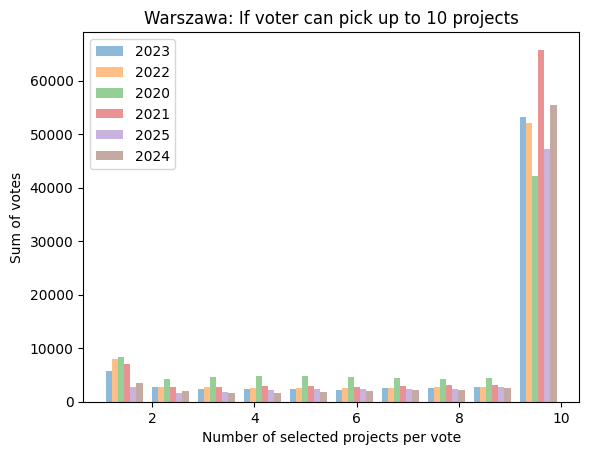

In [13]:
plt.hist(max_10_projects, alpha=0.5, label=max_10_projects_desc)
plt.title('Warszawa: If voter can pick up to 10 projects')
plt.ylabel('Sum of votes')
plt.xlabel('Number of selected projects per vote')
plt.legend(loc='upper left')
plt.show()

In [69]:

import math
import abc

print("Hello")
